# COMPAS-2 Analysis: Molecular Representation

This notebook contains the analysis of the molecular representation of the COMPAS-2 dataset. So far, we have only looked at the molecular representation based on EFCFP4 fingerprints and RDKit fingerprint. Preliminary results show that the `ECFP4 fingerprints` with `radius 6+` and `4096 bits` although suboptimal are the best performing molecular fingerprints for the COMPAS-2 dataset.

In [2]:
# import RDKit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from rdkit.Chem import rdFingerprintGenerator
# import pandasTools from rdkit
from rdkit.Chem import PandasTools

# import numpy and pandas
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# # improt dask
# import dask.dataframe as dd

# import plotly
import plotly.express as px
import plotly.graph_objects as go

# impot Path
from pathlib import Path

# imprt defaultdict
from collections import defaultdict

# show multiple outputs in one cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# InteractiveShell.ast_node_interactivity = "last_expr"


## Data Preprocessing

Before running the code below, make sure you have the necessary data files in the designated paths. If the pickle file containing preprocessed data doesn't exist, the following code will be executed to read the SDF and CSV files, perform necessary preprocessing steps, and save the data as a pickle file. If the pickle file already exists, the code will directly load the data from the pickle file.

After running the code, you can proceed with the analysis using the preprocessed data.


In [3]:
compas_2d_pkl = Path('.tempdata/compas-2D.pkl')
compas_2d_pkl.exists()

True

In [4]:
compas_2d_pkl = Path('.tempdata/compas-2D.pkl')

if not compas_2d_pkl.exists():
    # read .tempdata/compas-2D.sdf
    df = PandasTools.LoadSDF('.tempdata/compas-2D.sdf', smilesName='smi',molColName='mol',removeHs=False)
    df = df.query('charge == "0"')
    df = df.drop(columns=['energy'])
    # read csv file
    df2 = pd.read_csv('.tempdata/compas-2D.csv')
    # merge two dataframes
    df = df.merge(df2, on=['name', 'charge'])
    # save to .tempdata/compas-2D.pkl
    df.to_pickle('.tempdata/compas-2D.pkl')
else:
    df = pd.read_pickle('.tempdata/compas-2D.pkl')

## Molecular Fingerprint Generation and Visualization

The following code snippets demonstrate the process of molecular fingerprint generation using different methods and the visualization of generated fingerprints.

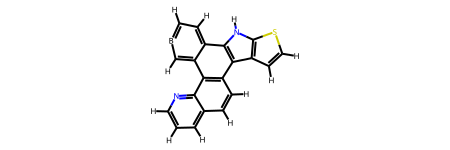

In [5]:
mol = df.iloc[36070]['mol']
mol

### RDKit Fingerprints
RDKit fingerprints utilize molecular paths to capture substructure presence and connectivity, considering bond types and branching. They offer versatility in representing various molecular features, and the maxPath parameter controls the path length.

[2, 4, 6, 22, 25, 35, 48, 50, 62, 70]

[6, 22, 25, 35, 48, 50, 70, 99, 107, 109]

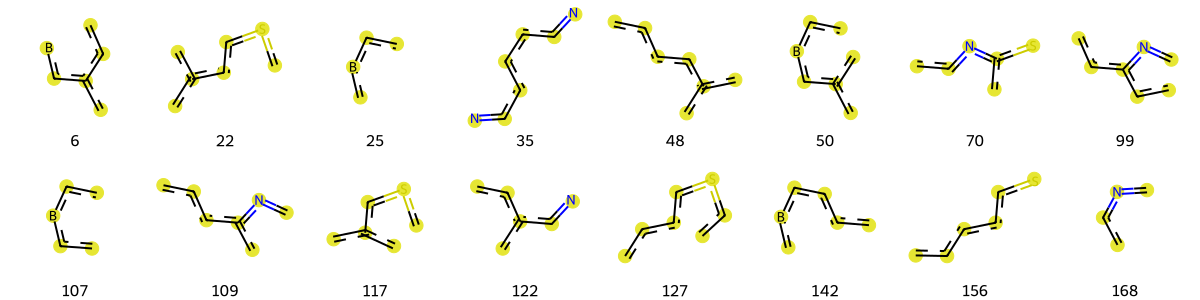

In [6]:
bi = {}
fpgen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=6,
                                                    useBondOrder=False,
                                                    branchedPaths=True,
                                                    useHs=False
                                                    )

ao = rdFingerprintGenerator.AdditionalOutput()
ao.AllocateAtomCounts()
ao.AllocateAtomToBits()
ao.AllocateBitInfoMap()
ao.AllocateBitPaths()
fp = fpgen.GetFingerprint(mol,additionalOutput=ao)
list(fp.GetOnBits())[:10]
bi = ao.GetBitPaths()
list(bi.keys())[:10]
tpls = [(mol, bo, bi) for bo in list(bi.keys())[:16]]
Draw.DrawRDKitBits(tpls, molsPerRow=8, legends=[str(bo) for _, bo, _ in tpls])


### Morgan Fingerprints

Morgan fingerprints, also called ECFP, encode local structural features by capturing circular substructures around each atom in a molecule. The radius parameter controls the size of the patterns, and the fingerprint size determines the representation length.

([12, 32, 45, 71, 76, 98, 115, 116, 119, 147],
 [12, 32, 45, 71, 76, 98, 115, 116, 119, 147])

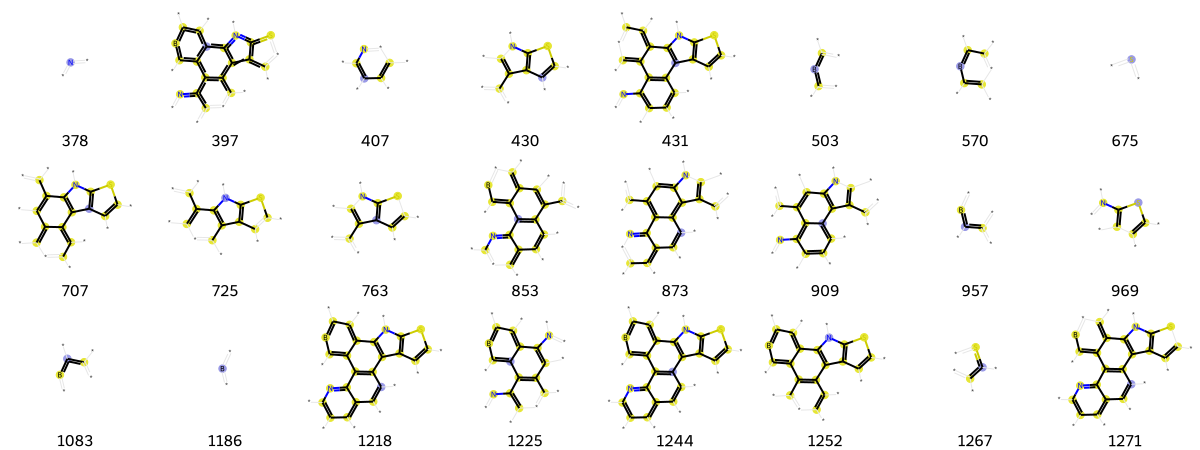

In [7]:
bi = {}
fpgen = rdFingerprintGenerator.GetMorganGenerator(fpSize=4096,
                                                radius=6,
                                                useBondTypes=False,
                                                includeRingMembership=True,
                                                # useHs=False
                                                    )

ao = rdFingerprintGenerator.AdditionalOutput()
ao.AllocateAtomCounts()
ao.AllocateAtomToBits()
ao.AllocateBitInfoMap()
ao.AllocateBitPaths()
fp = fpgen.GetFingerprint(mol,additionalOutput=ao)

bi = ao.GetBitInfoMap()
list(bi.keys())[:10],list(fp.GetOnBits())[:10]

bits_idx = 12
tpls = [(mol, bo, bi) for bo in list(bi.keys())][bits_idx:bits_idx+24]
Draw.DrawMorganBits(tpls,molsPerRow=8,
 legends=[str(bo) for _, bo, _ in tpls])

In [8]:
# calculate Morgan Fingerprint for each molecule 
%time fps = df['mol'].apply(lambda x: fpgen.GetFingerprint(x))
df['morgan'] = fps
# convert to numpy array
df['morgan_arr'] = [np.array(x) for x in df['morgan']]

CPU times: total: 2.69 s
Wall time: 19.3 s


### Assessing the capabilities of the fingerprints to represent molecules

In [9]:
from rdkit.DataManip.Metric import GetTanimotoDistMat, GetTanimotoSimMat
from rdkit import DataStructs

In [230]:
# %time 

# %time simmat = GetTanimotoSimMat(df['morgan'].iloc[:20000].values)
# simmat = simmat.astype(np.float16)

class MatrixFromArr():
    """
    This class is used to access the one-dimensional array containing the lower triangle elements of the symmetric distance matrix in a two-dimensional manner.
    """
    def __init__(self, arr):
        self.arr = arr
        self.n = len(arr)
        self.m = get_m(self.n)
        self.shape = (self.m, self.m)

    def get_m(self, n):
        return (1 + np.sqrt(1+8*n))//2
    
    def get_n(self, m):
        return (m*m - m)//2

    def __getitem__(self, idx):
        idx = list(idx)
        idx.sort(reverse=True)
        if idx[0] == idx[1]:
            return 1
        item = self.arr[self.get_n(idx[0]) + idx[1]]
        return item        

    def __len__(self):
        return self.m * self.m

simmat = MatrixFromArr(simmat.arr)

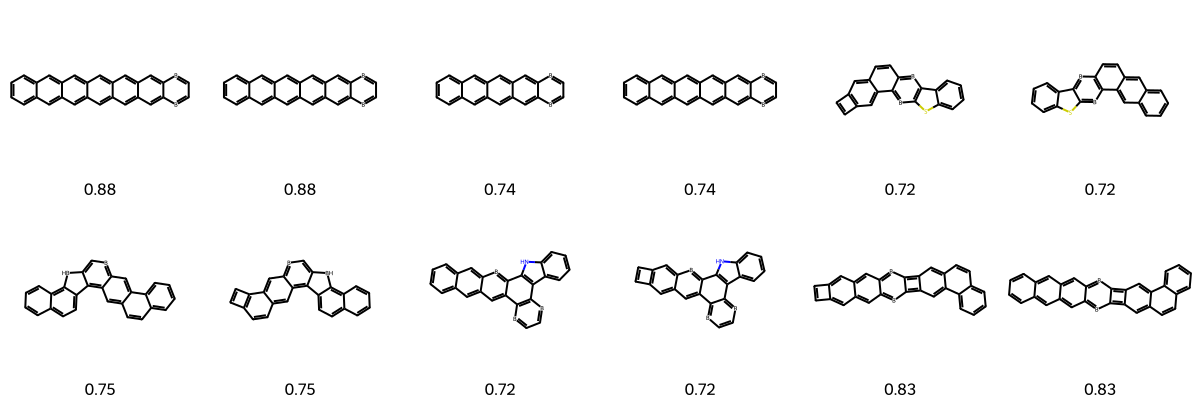

In [307]:
# (similarity_matrix > 0.2).sum()
# get the indices where the similarity is greater than 0.2
# np.where(similarity_matrix > 0.25)[0][0],np.where(similarity_matrix > 0.2)[1][0]
# draw mols to grids
def draw_similar_pair(similarity_matrix,smiles, threshold=0.2, molsPerRow=2, subImgSize=(300,300), maxMols=10):
    # get the indices where the similarity is greater than 0.2
    indices = np.where(similarity_matrix > threshold)
    # get the first pair of indices
    mols = []
    legends = []
    for i in range(len(indices[0])):
        if indices[0][i] != indices[1][i]:
            mols += [Chem.MolFromSmiles(smiles[indices[0][i]]),
                        Chem.MolFromSmiles(smiles[indices[1][i]])]
            legends += 2*[str(round(similarity_matrix[indices[0][i],indices[1][i]],2))]
    # draw the mols
    # legends=[str(round(similarity_matrix[indices[0][i],indices[1][i]],2)) for i in range(len(indices[0]))]
    return Draw.MolsToGridImage(mols[:maxMols],molsPerRow=molsPerRow,subImgSize=subImgSize,legends=legends[:maxMols])

draw_similar_pair(sm, df['smiles'],threshold=0.7,maxMols=12,molsPerRow=6,subImgSize=(200,200))

<AxesSubplot: >

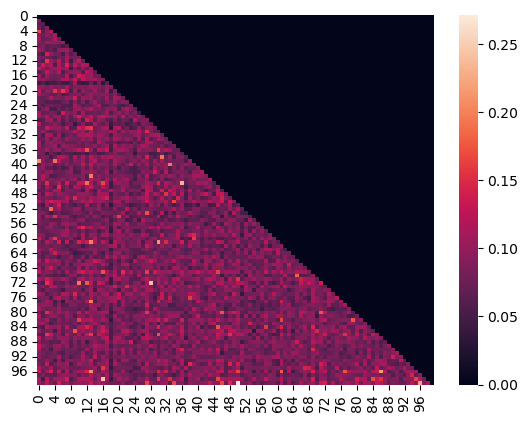

In [259]:
# plot heat map of the simmilarity matrix
sns.heatmap(sm[:100,:100])

### Mol2Vec
Mol2Vec is an approach that represents molecules as continuous vectors in a high-dimensional space, often utilizing techniques from natural language processing, like Word2Vec. It transforms molecular structures into embeddings where similar molecules are located closer in vector space. Mol2Vec captures semantic relationships between molecules and can be used for similarity search and machine learning tasks in cheminformatics and drug discovery.

### LALAs

 LALAS is a string-based representations of PHBs molecules that express the annulation pattern of the molecules in term of Antracene (L) and Phenanthrene (A) subuints. There are two levels of LALAs representation so far. The first type uses only capital letters and provides no information about angular annulation directionality. These result in strings of varying lengths composed of "L" and "A" letters, known as LALA Strings. The second type employs both uppercase "A" and lowercase "a" to indicate angular annulation directionality, referred to as augmented-LALAS. The augmented-LALAS representation is equivalent to Balaban's code and maintains the same uniqueness and invertibility between names and structures. 